# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from tqdm import tqdm
from skimage.transform import resize
import torchvision.utils as vutils
from torchvision import transforms
from mpl_toolkits.axes_grid1 import ImageGrid

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Preprocess and Save

### Load Preporcessed Dataset

In [3]:
# loading images
images_l = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images100000") # 26.40
images_l_75 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images75000") # 26.38
images_l_50 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images50000") # 33.55
images_l_25 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images25000") # 41.04
images_l_125 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images125000") # 30.82
images_l_150 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images150000") # 41.99
images_l_175 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images175000") # 43.47
images_l_200 = load_obj_real("/work/kabaeuer/logs/imagewoof_32_highDim_2022_04_03_18_55_01/Samples/images200000") # 39.9

50000


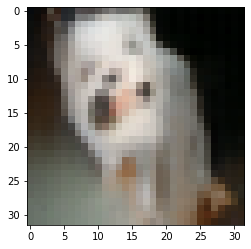

In [4]:
# Example image
print(len(images_l))
imgplot = plt.imshow(images_l[1])
plt.show()

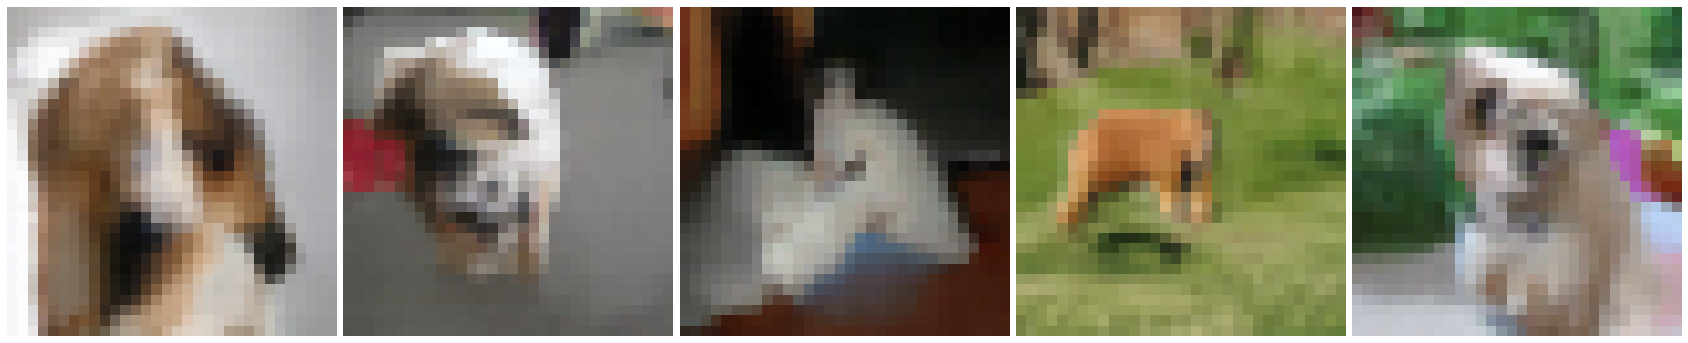

In [5]:
im1 = images_l[3120]
im2 = images_l[4]
im3 = images_l[13]
im4 = images_l[865]
im5 = images_l[12312]

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [im1, im2, im3, im4, im5]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()
plt.show()

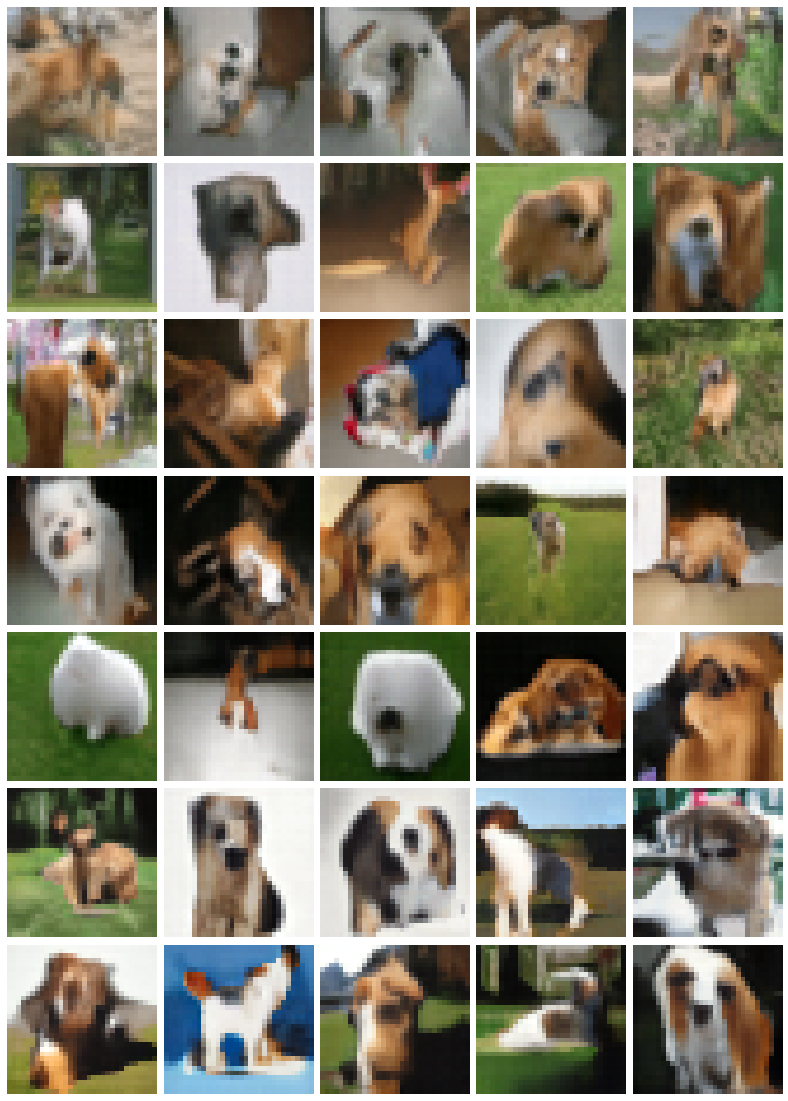

In [6]:
images_epoch = []
for im_set in [images_l_25, images_l_50, images_l_75, images_l, images_l_125, images_l_175, images_l_200]:
    images_epoch.append(im_set[1])
    images_epoch.append(im_set[10])
    images_epoch.append(im_set[100])
    images_epoch.append(im_set[1000])
    images_epoch.append(im_set[10000])
                
fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(7, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, images_epoch):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()
plt.show()

## Real Images

In [7]:
images_real = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageWoof/imagewoof_images")

12954


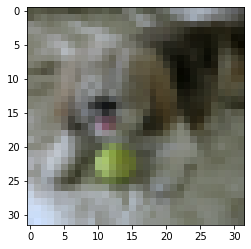

In [8]:
# Example image
print(len(images_real))
imgplot = plt.imshow(images_real[0])
plt.show()

# Analyzing Images

## Creating FFT

In [9]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [10]:
# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

### Generated Images

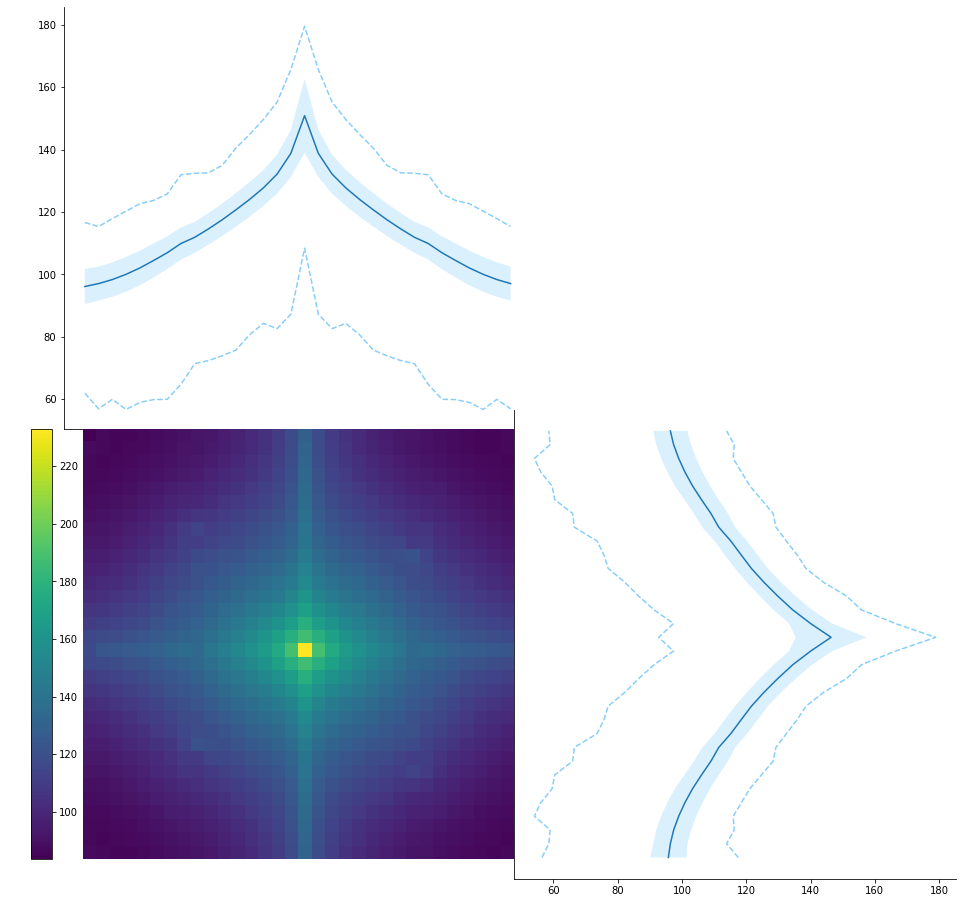

In [11]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g)

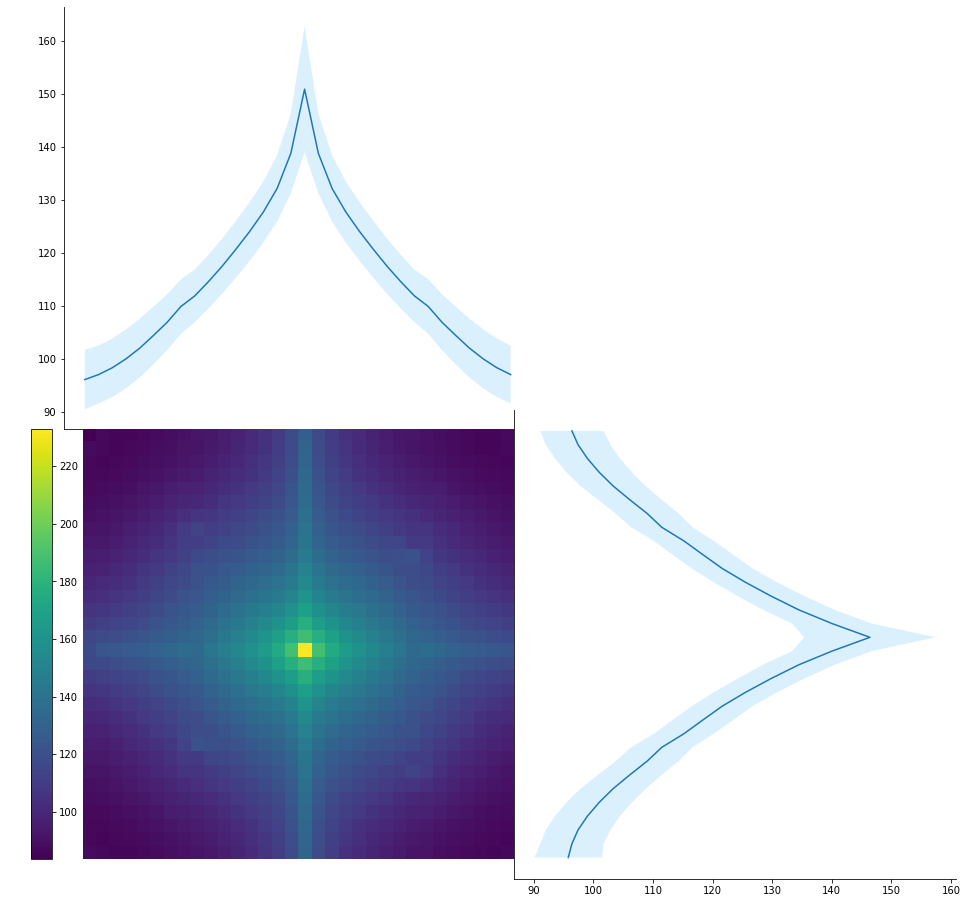

In [12]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Normalized

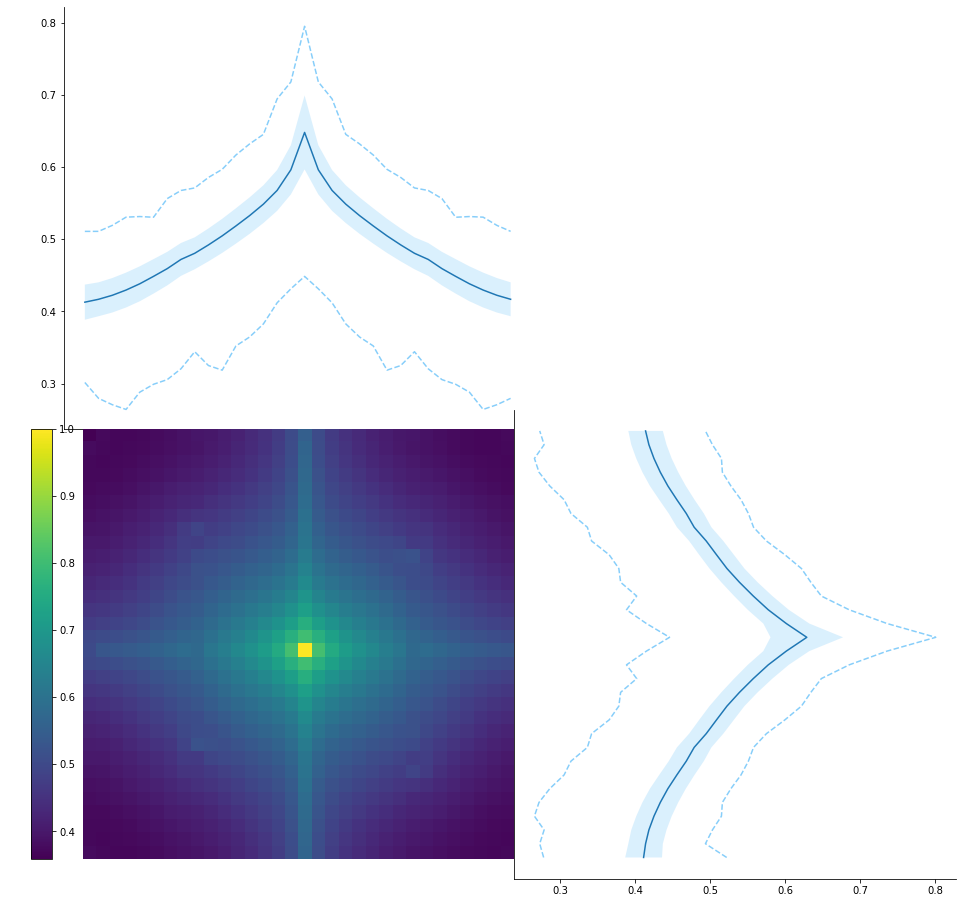

In [13]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = True)

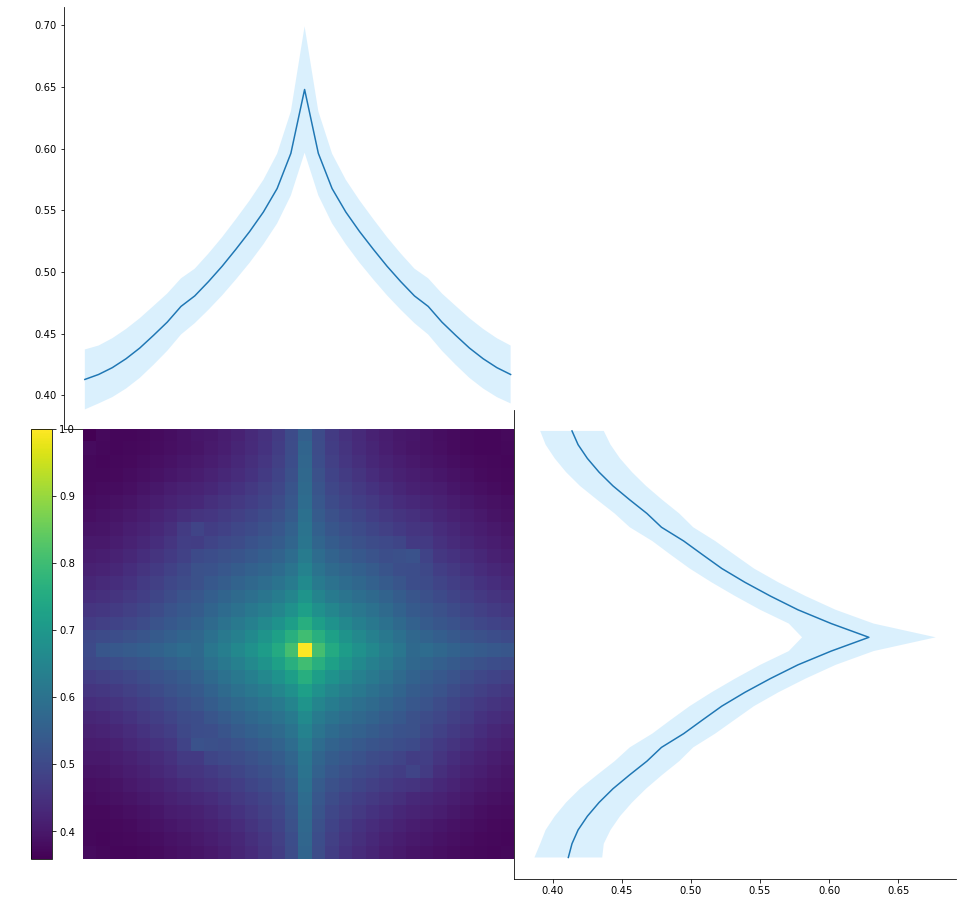

In [14]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l, True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Real Images

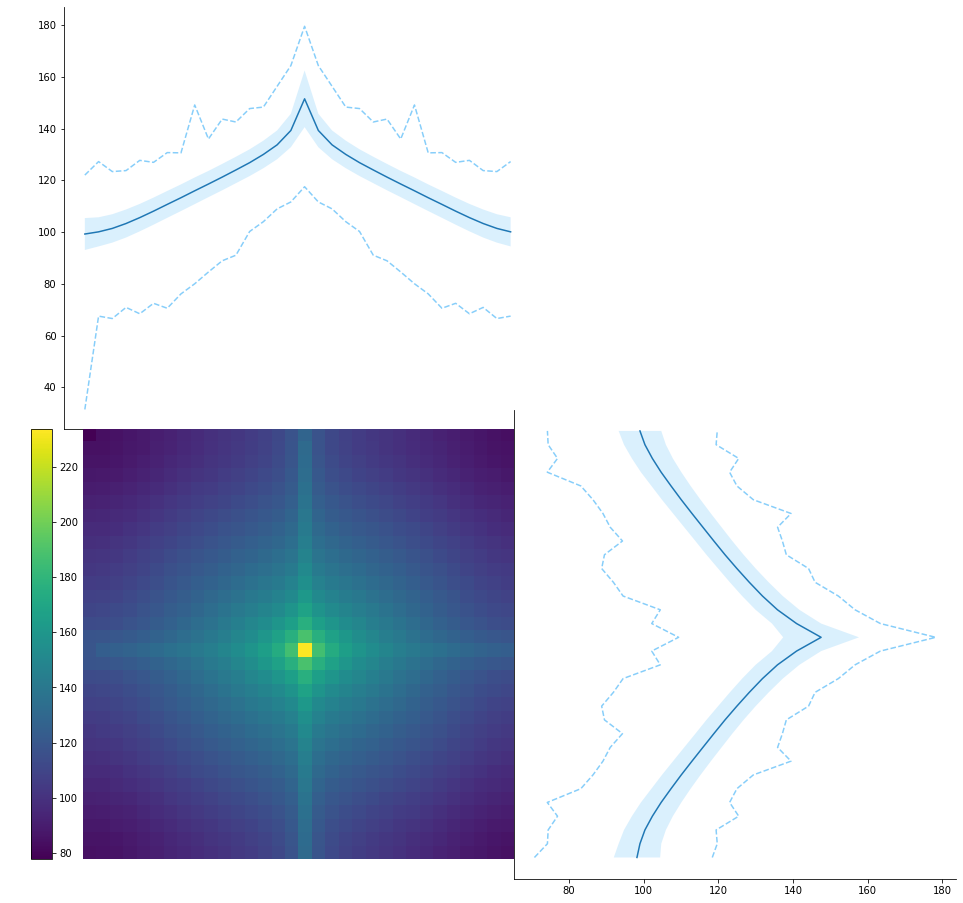

In [15]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

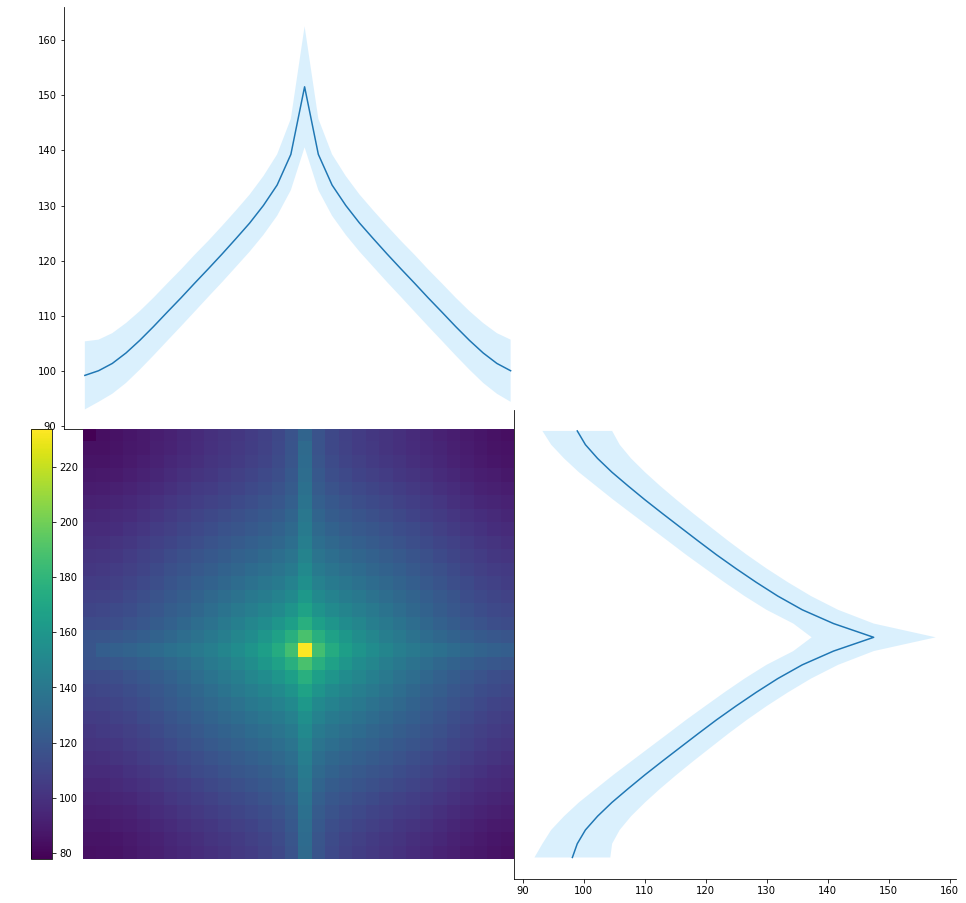

In [16]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Normalized

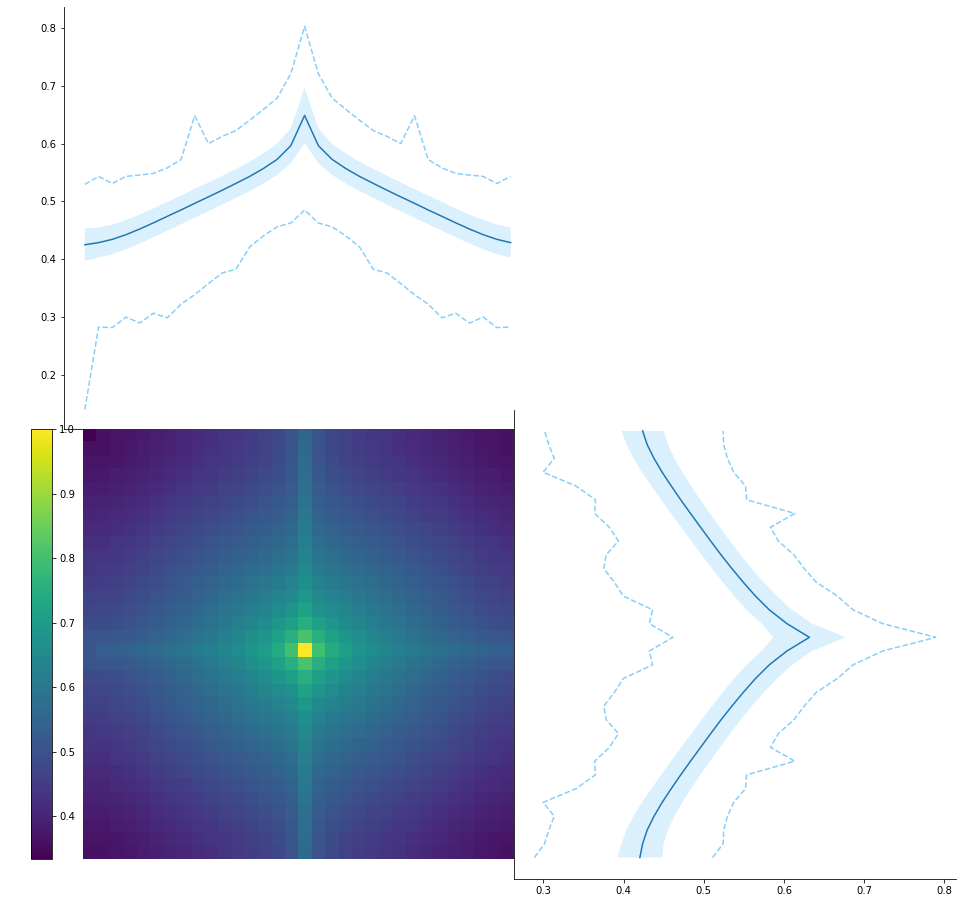

In [17]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

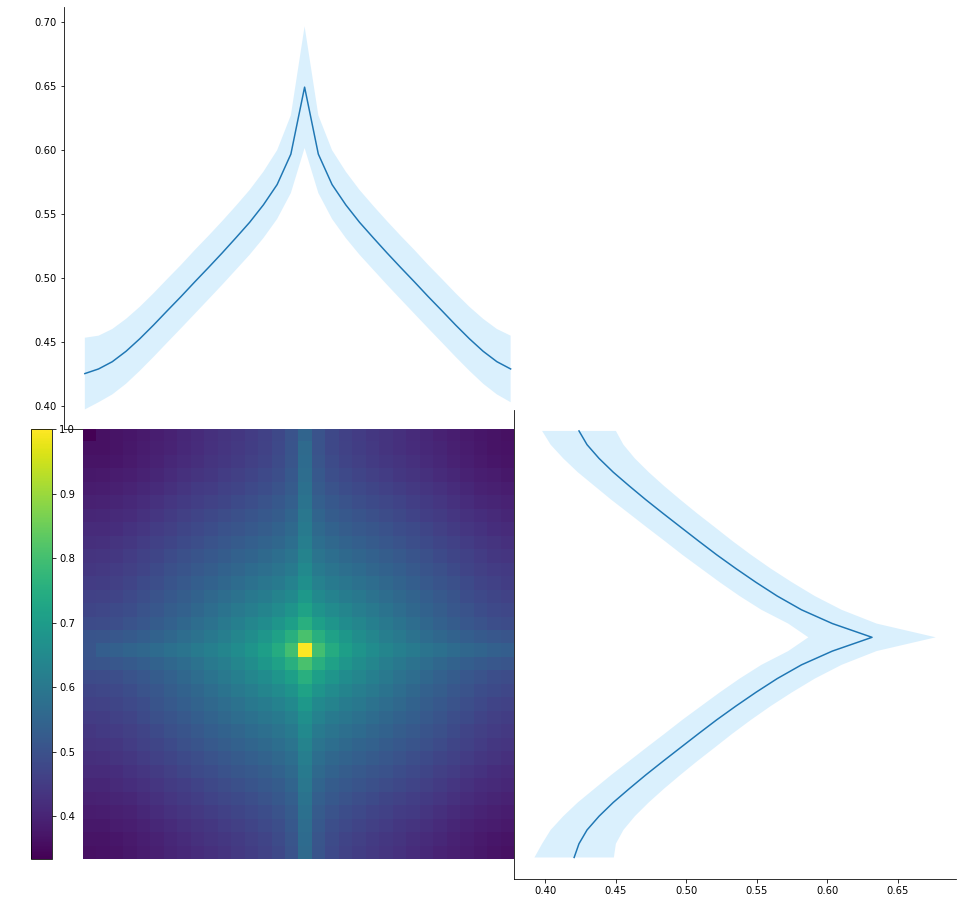

In [18]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Real vs Fake

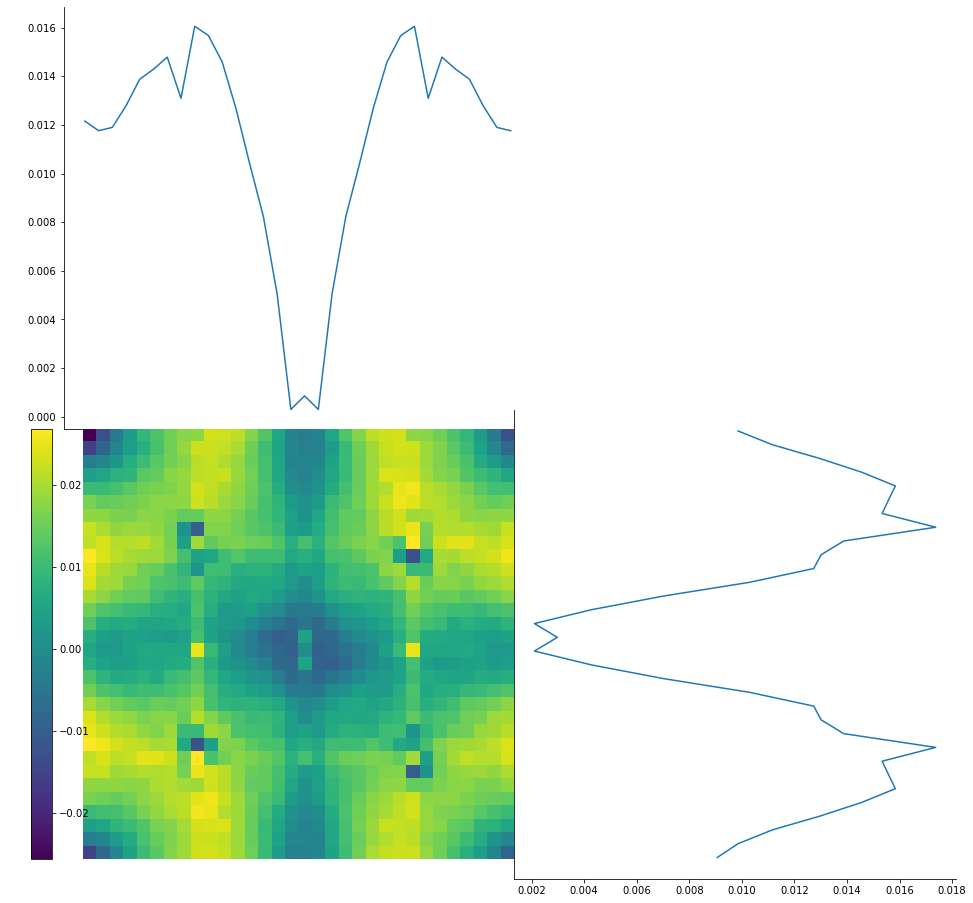

In [19]:
create_comparison_plot(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="TransGAN")

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

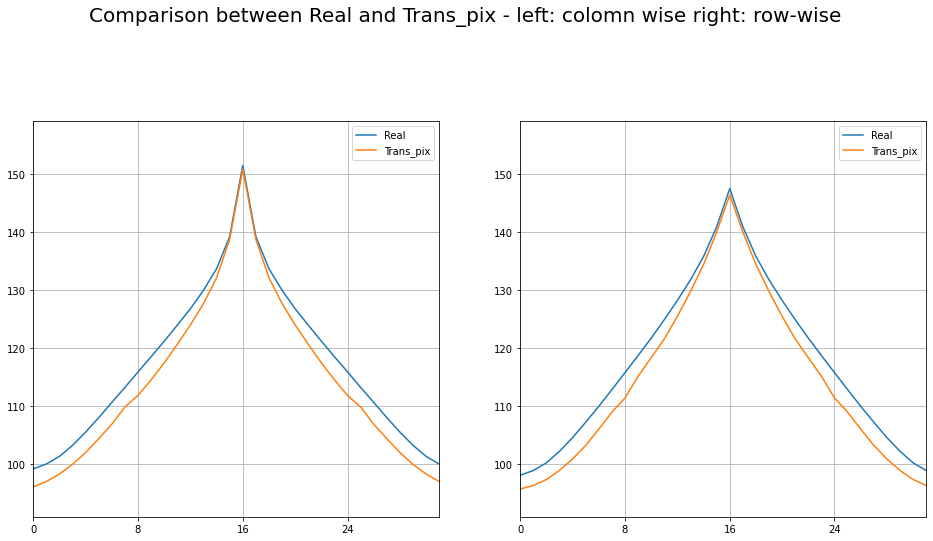

In [20]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.grid()
ax2.grid()
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g, label='Trans_pix')
ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g, label='Trans_pix')
ymin = min(min(zero_axis_r),min(zero_axis_g),min(one_axis_r),min(one_axis_g))
ymax = max(max(zero_axis_r),max(zero_axis_g),max(one_axis_r),max(one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

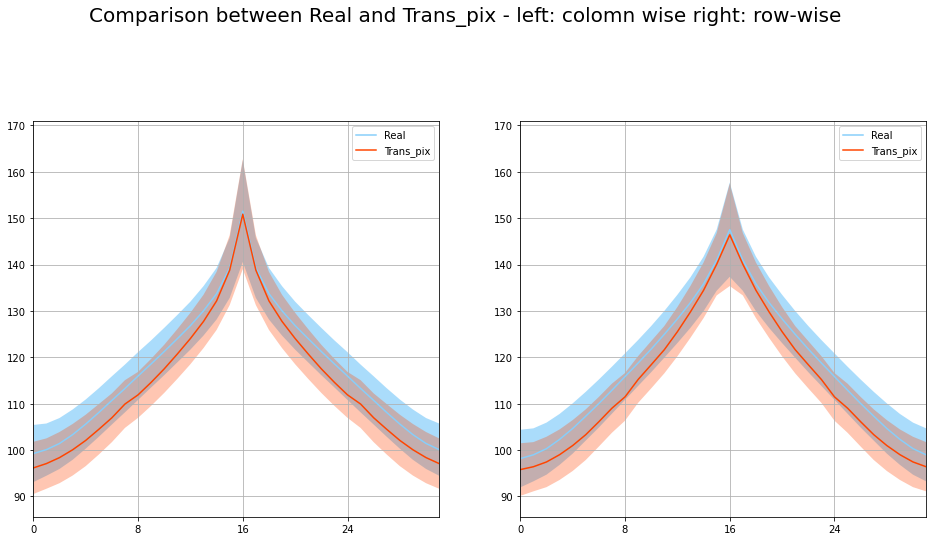

In [21]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g, label='Trans_pix', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g + std_zero_axis_g, zero_axis_g -std_zero_axis_g,facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g, label='Trans_pix',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g + std_one_axis_g, one_axis_g -std_one_axis_g,facecolor='orangered', alpha=0.3)
leg = ax1.legend()
leg = ax2.legend()
ymin = min(min(zero_axis_r-std_zero_axis_r),min(zero_axis_g-std_zero_axis_g),min(one_axis_r-std_one_axis_r),min(one_axis_g-std_one_axis_g))
ymax = max(max(zero_axis_r+std_zero_axis_r),max(zero_axis_g+std_zero_axis_g),max(one_axis_r+std_one_axis_r),max(one_axis_g+std_one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

### Normalized

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

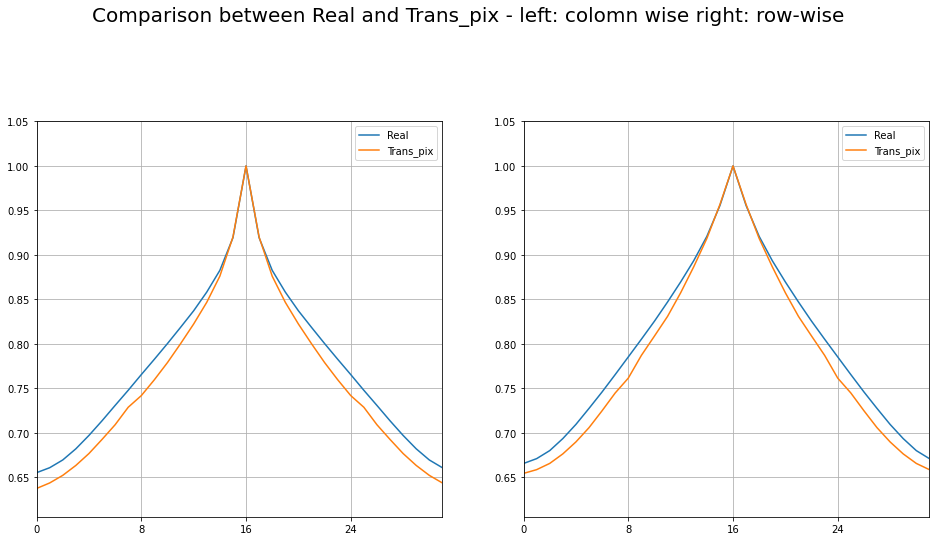

In [22]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g/zero_axis_g.max(), label='Trans_pix')
ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='Trans_pix')
ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

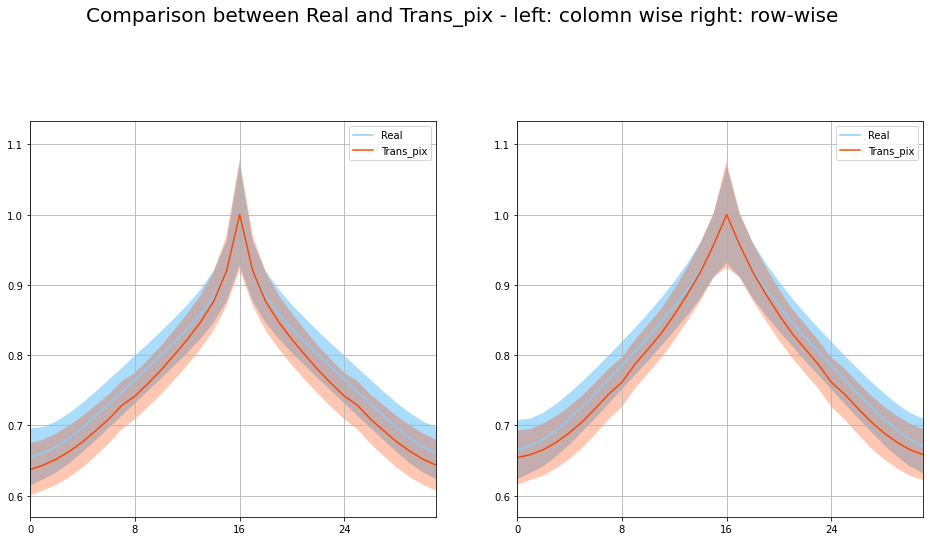

In [23]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max(), zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g/zero_axis_g.max(), label='Trans_pix', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max(), zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max(),facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max(), one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='Trans_pix',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max(), one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max(),facecolor='orangered', alpha=0.3)

ymin = min(min(zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

### Real vs Fake relative

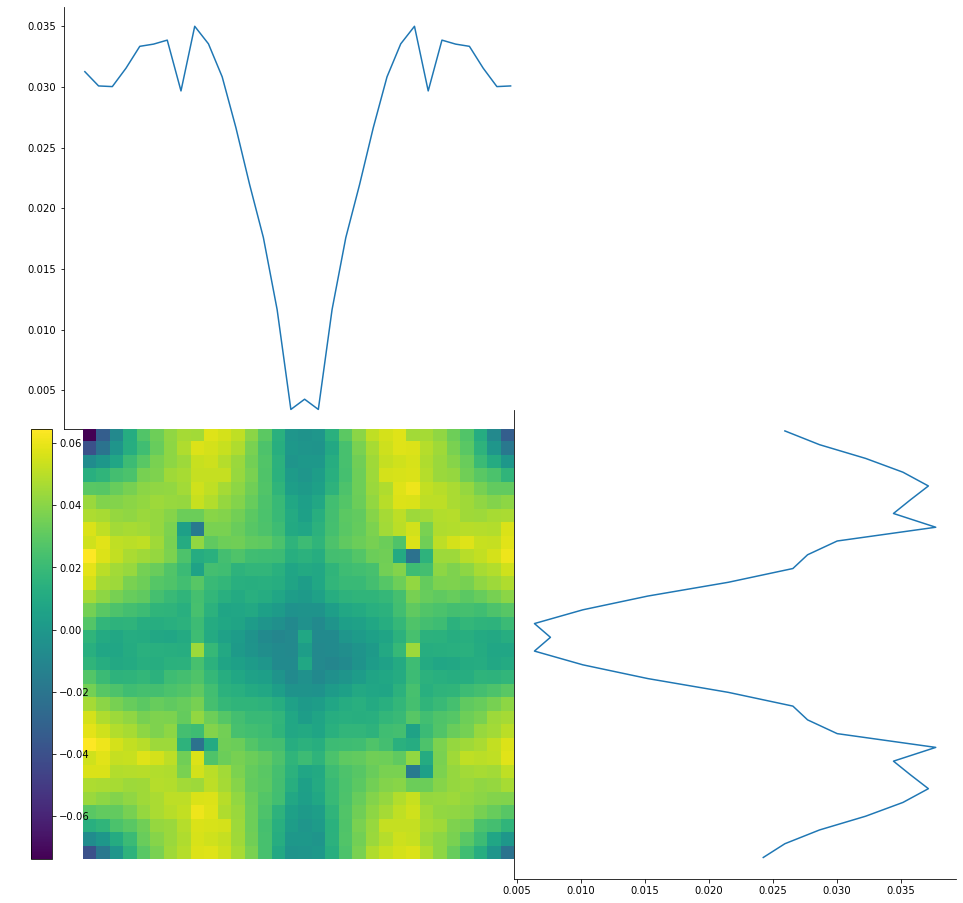

In [24]:
create_comparison_plot_rel(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="Trans_pix")

## FID-Calucluations

In [25]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(real_img, fake_img):
    
    mu1 = real_img.mean(axis=0)
    sigma1 = cov(real_img, rowvar=False)
    mu2 = fake_img.mean(axis=0)
    sigma2 = cov(fake_img, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [26]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()])
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()])
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 9644.31it/s]


FID:  16078.76210639514


### Normalized

In [27]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()]/np.array(fft(images_real[_])).flatten().max())
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()]/np.array(fft(images_l[_])).flatten().max())
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2884.44it/s]


FID:  0.26364516108255187


# Epochs

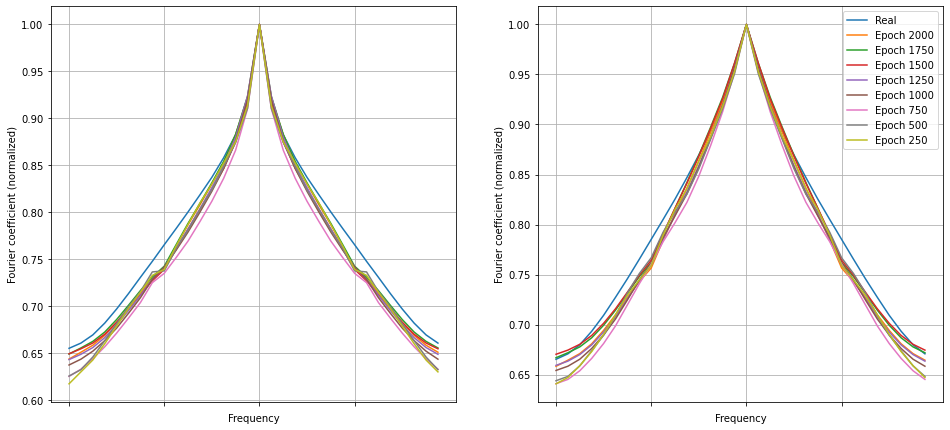

In [28]:
two_dim_g_1, zero_axis_g_1, one_axis_g_1, m_g_1, n_g_1,min_zero_axis_g_1,max_zero_axis_g_1, min_one_axis_g_1, max_one_axis_g_1, std_zero_axis_g_1, std_one_axis_g_1 = create_informations(images_l,False)
two_dim_g_2, zero_axis_g_2, one_axis_g_2, m_g_2, n_g_2,min_zero_axis_g_2,max_zero_axis_g_2, min_one_axis_g_2, max_one_axis_g_2, std_zero_axis_g_2, std_one_axis_g_2 = create_informations(images_l_75,False)
two_dim_g_3, zero_axis_g_3, one_axis_g_3, m_g_3, n_g_3,min_zero_axis_g_3,max_zero_axis_g_3, min_one_axis_g_3, max_one_axis_g_3, std_zero_axis_g_3, std_one_axis_g_3 = create_informations(images_l_50,False)
two_dim_g_4, zero_axis_g_4, one_axis_g_4, m_g_4, n_g_4,min_zero_axis_g_4,max_zero_axis_g_4, min_one_axis_g_4, max_one_axis_g_4, std_zero_axis_g_4, std_one_axis_g_4 = create_informations(images_l_25,False)
two_dim_g_5, zero_axis_g_5, one_axis_g_5, m_g_5, n_g_5,min_zero_axis_g_5,max_zero_axis_g_5, min_one_axis_g_5, max_one_axis_g_5, std_zero_axis_g_5, std_one_axis_g_5 = create_informations(images_l_125,False)
two_dim_g_6, zero_axis_g_6, one_axis_g_6, m_g_6, n_g_6,min_zero_axis_g_6,max_zero_axis_g_6, min_one_axis_g_6, max_one_axis_g_6, std_zero_axis_g_6, std_one_axis_g_6 = create_informations(images_l_150,False)
two_dim_g_7, zero_axis_g_7, one_axis_g_7, m_g_7, n_g_7,min_zero_axis_g_7,max_zero_axis_g_7, min_one_axis_g_7, max_one_axis_g_7, std_zero_axis_g_7, std_one_axis_g_7 = create_informations(images_l_175,False)
two_dim_g_8, zero_axis_g_8, one_axis_g_8, m_g_8, n_g_8,min_zero_axis_g_8,max_zero_axis_g_8, min_one_axis_g_8, max_one_axis_g_8, std_zero_axis_g_8, std_one_axis_g_8 = create_informations(images_l_200,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_g_8)),zero_axis_g_8/zero_axis_g_8.max(), label='Epoch 2000')
ax1.plot(range(len(zero_axis_g_7)),zero_axis_g_7/zero_axis_g_7.max(), label='Epoch 1750')
ax1.plot(range(len(zero_axis_g_6)),zero_axis_g_6/zero_axis_g_6.max(), label='Epoch 1500')
ax1.plot(range(len(zero_axis_g_5)),zero_axis_g_5/zero_axis_g_5.max(), label='Epoch 1250')
ax1.plot(range(len(zero_axis_g_1)),zero_axis_g_1/zero_axis_g_1.max(), label='Epoch 1000')
ax1.plot(range(len(zero_axis_g_2)),zero_axis_g_2/zero_axis_g_2.max(), label='Epoch 750')
ax1.plot(range(len(zero_axis_g_3)),zero_axis_g_3/zero_axis_g_3.max(), label='Epoch 500')
ax1.plot(range(len(zero_axis_g_4)),zero_axis_g_4/zero_axis_g_4.max(), label='Epoch 250')


ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_g_8)),one_axis_g_8/one_axis_g_8.max(), label='Epoch 2000')
ax2.plot(range(len(one_axis_g_7)),one_axis_g_7/one_axis_g_7.max(), label='Epoch 1750')
ax2.plot(range(len(one_axis_g_6)),one_axis_g_6/one_axis_g_6.max(), label='Epoch 1500')
ax2.plot(range(len(one_axis_g_5)),one_axis_g_5/one_axis_g_5.max(), label='Epoch 1250')
ax2.plot(range(len(one_axis_g_1)),one_axis_g_1/one_axis_g_1.max(), label='Epoch 1000')
ax2.plot(range(len(one_axis_g_2)),one_axis_g_2/one_axis_g_2.max(), label='Epoch 750')
ax2.plot(range(len(one_axis_g_3)),one_axis_g_3/one_axis_g_3.max(), label='Epoch 500')
ax2.plot(range(len(one_axis_g_4)),one_axis_g_4/one_axis_g_4.max(), label='Epoch 250')


#ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max()))
#ymax = max(max(zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max()))
#ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
#ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
#leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.grid()
ax2.grid()
#fig.suptitle("Comparison between Real and TransGAN - left: colomn wise right: row-wise", fontsize=20)